In [55]:

from torch_geometric.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import (GINConv,global_add_pool,GATConv,ChebConv,GCNConv)
from torch_geometric.datasets import ZINC
from torch_geometric.utils import to_networkx, to_dense_adj
import geoopt
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from torch_geometric.data import InMemoryDataset

from libs.spect_conv import SpectConv,ML3Layer
from libs.utils import Zinc12KDataset,SpectralDesign,get_n_params
from utils_1 import get_graph_props, make_2d_graph
from torch_geometric.data import Data
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Union

import torch
from torch import Tensor

from torch_geometric.data.collate import collate

from tqdm import tqdm
import argparse


import os
#os.environ["WANDB_MODE"]="dryrun"

In [56]:
transform = SpectralDesign(nmax=37,recfield=2,dv=2,nfreq=7) 

#dataset = Zinc12KDataset(root="graph-task/dataset/ZINC/",pre_transform=transform)
#dataset = Zinc12KDataset(root="graph-task/dataset/ZINC/",pre_transform=transform) #For Ali

########## commented this:
dataset = Zinc12KDataset(root="dataset/ZINC/",pre_transform=transform) #For Sohir

In [57]:
from libs.utils import Model_RGD,training_loop1,get_orthonromal_eigvec

In [148]:
num_eigs =2
epochs = 1000
device = 'cpu'
p=1

In [149]:
from torch_geometric.utils.convert import to_networkx

In [150]:
data = dataset[1]
    #Preprocessing
cora_adj = to_dense_adj(data.edge_index)
cora_adj.squeeze_()

A = cora_adj.numpy()
D, L, L_inv, eigval,eigvec = get_graph_props(A,normalize_L='none')

#We transform our eigenvectors into an orthonormalbasis such that it is in the Stiefel manifold

#Just removed for L_2 LPE


hi = get_orthonromal_eigvec(eigval,eigvec)
"""

gg = to_networkx(data)
g = dgl.from_networkx(gg)
tau=0
A = g.adjacency_matrix_scipy(return_edge_ids=False).astype(float).toarray() + tau / g.number_of_nodes()
D = np.diag((dgl.backend.asnumpy(g.in_degrees()).clip(1) + tau))
L = D-A

# Eigenvectors with PYTORCH
# Reason: pytorch has the fct torch.linalg.eigh which directly gives an ONB.
eigval, eigvec = torch.linalg.eigh(torch.tensor(L))
eigval = eigval.numpy()
eigvec = eigvec.numpy()

idx = eigval.argsort() # increasing order
eigval, eigvec = eigval[idx], np.real(eigvec[:,idx])
hi = eigvec
"""

n= eigval.shape[0]
K = num_eigs
epochs = epochs

# instantiate model
W = torch.tensor(A).float().to(device)
F_ = torch.tensor(hi[:, :num_eigs]).float().to(device) #We can use previous outputs weight
m = Model_RGD(F_, p, n, num_eigs, ball = geoopt.EuclideanStiefelExact()).to(device) #I think we should not use F_ at initizialization, rather as a forward input so that we can start different init, or just use the reset parameters differently

# Instantiate optimizer
#opt = torch.optim.Adam(params=m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = geoopt.optim.RiemannianSGD(m.parameters(), lr=1e-2)
#optimizer = geoopt.optim.RiemannianSGD(m.parameters(), lr=1e-2, momentum=0.9)

decayRate = 0.99
my_lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer)#, gamma=decayRate)
#my_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=1, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
#my_lr_scheduler = None

#Learn the 1-eigenvector. It is then given by m.weight
start = timer()
losses = training_loop1(m, optimizer,my_lr_scheduler,W, epochs)  
end = timer()
print(end - start, " Second")

m.to('cpu')

1.3959799039876089  Second


Model_RGD(
  (ball): Stiefel(euclidean)(exact) manifold
)

In [151]:
data = dataset[1]
    #Preprocessing
cora_adj = to_dense_adj(data.edge_index)
cora_adj.squeeze_()

A = cora_adj.numpy()
D, L, L_inv, eigval,eigvec = get_graph_props(A,normalize_L='none')

#We transform our eigenvectors into an orthonormalbasis such that it is in the Stiefel manifold

#Just removed for L_2 LPE


hi = get_orthonromal_eigvec(eigval,eigvec)
"""

gg = to_networkx(data)
g = dgl.from_networkx(gg)
tau=0
A = g.adjacency_matrix_scipy(return_edge_ids=False).astype(float).toarray() + tau / g.number_of_nodes()
D = np.diag((dgl.backend.asnumpy(g.in_degrees()).clip(1) + tau))
L = D-A

# Eigenvectors with PYTORCH
# Reason: pytorch has the fct torch.linalg.eigh which directly gives an ONB.
eigval, eigvec = torch.linalg.eigh(torch.tensor(L))
eigval = eigval.numpy()
eigvec = eigvec.numpy()

idx = eigval.argsort() # increasing order
eigval, eigvec = eigval[idx], np.real(eigvec[:,idx])
hi = eigvec
"""

n= eigval.shape[0]
K = num_eigs
epochs = epochs

# instantiate model
W = torch.tensor(A).float().to(device)
F_ = torch.tensor(hi[:, :num_eigs]).float().to(device) #We can use previous outputs weight
m2 = Model_RGD(F_, p, n, num_eigs, ball = geoopt.EuclideanStiefelExact()).to(device) #I think we should not use F_ at initizialization, rather as a forward input so that we can start different init, or just use the reset parameters differently

# Instantiate optimizer
#opt = torch.optim.Adam(params=m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = geoopt.optim.RiemannianSGD(m.parameters(), lr=1e-2)
#optimizer = geoopt.optim.RiemannianSGD(m.parameters(), lr=1e-2, momentum=0.9)

decayRate = 0.99
#my_lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer)#, gamma=decayRate)
#my_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=1, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
my_lr_scheduler = None

#Learn the 1-eigenvector. It is then given by m.weight
start = timer()
losses = training_loop1(m2, optimizer,my_lr_scheduler,W, epochs)  
end = timer()
print(end - start, " Second")

m2.to('cpu')

1.51157863100525  Second


Model_RGD(
  (ball): Stiefel(euclidean)(exact) manifold
)

In [152]:
m.forward(W)

tensor(0.2051, grad_fn=<SumBackward0>)

In [153]:
m2.forward(W)

tensor(0.2953, grad_fn=<SumBackward0>)

In [130]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, colors, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
        
    layout = nx.fruchterman_reingold_layout(g)
    vmin = colors.min()
    vmax = colors.max()
    cmap = plt.cm.Spectral
  
    
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color=colors, cmap=cmap)
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g

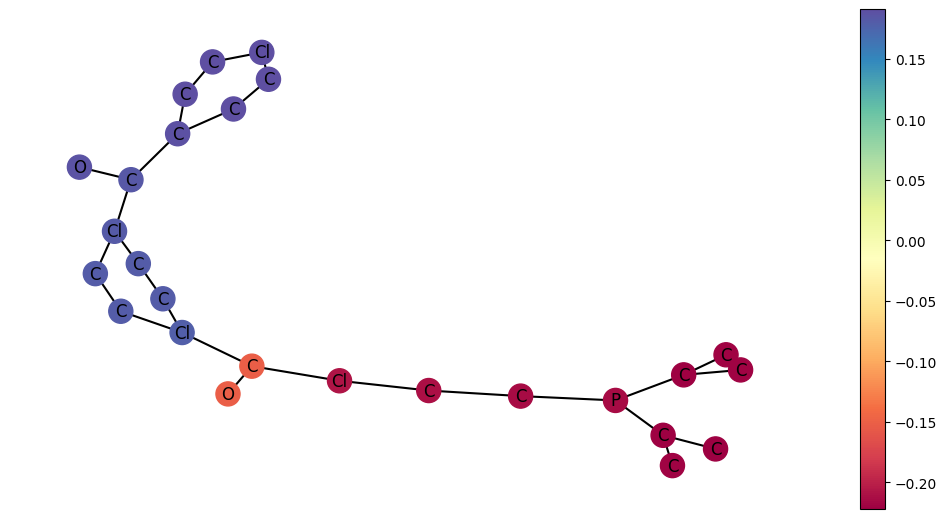

In [154]:
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, m.to("cpu").weight.detach().numpy()[:,1])

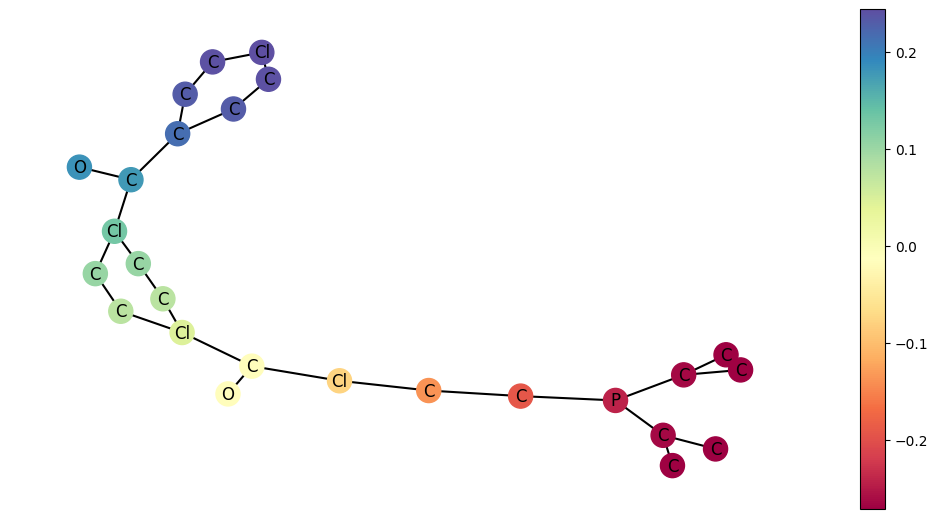

In [155]:
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, m2.to("cpu").weight.detach().numpy()[:,1])

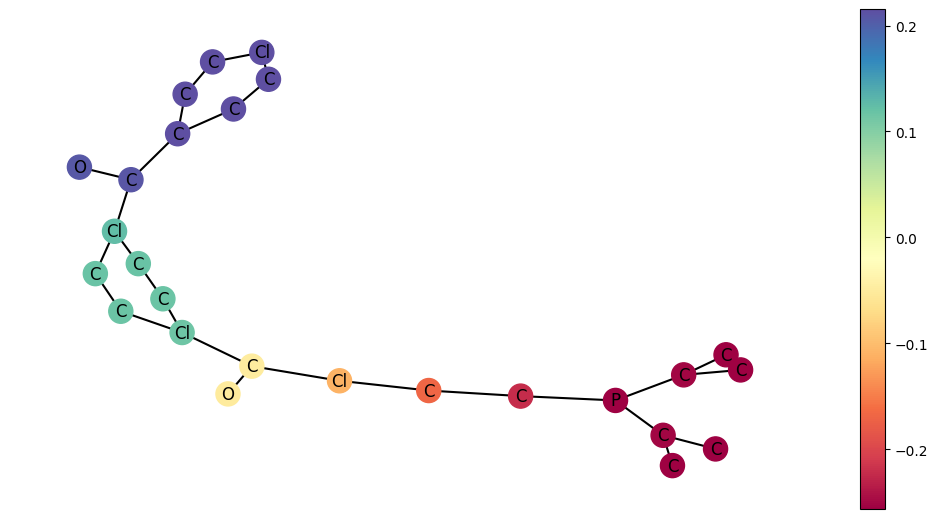

In [145]:
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, m.to("cpu").weight.detach().numpy()[:,1])

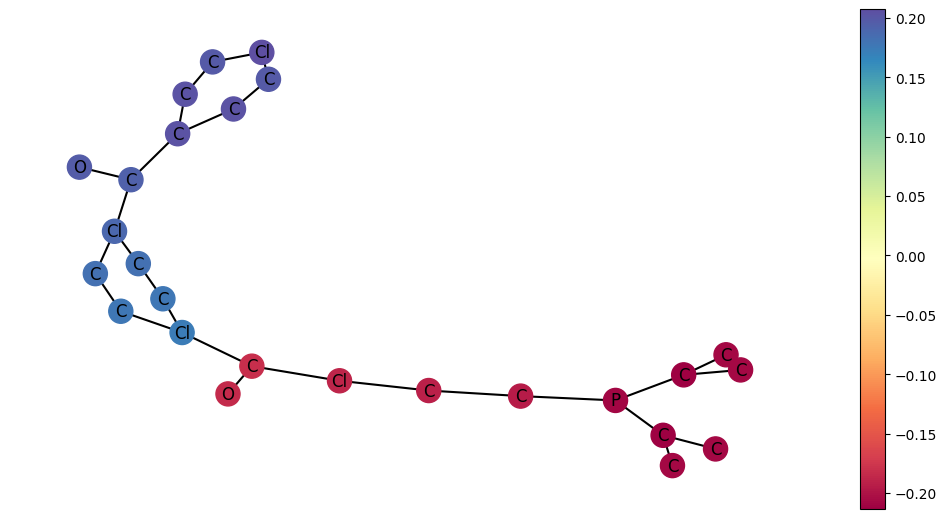

In [89]:
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, m.to("cpu").weight.detach().numpy()[:,1])

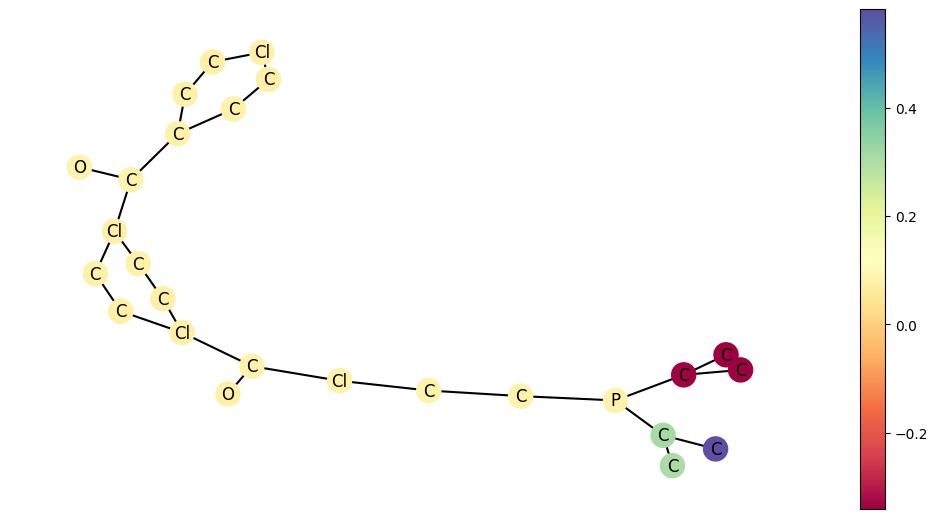

In [323]:
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, m.to("cpu").weight.detach().numpy()[:,3])

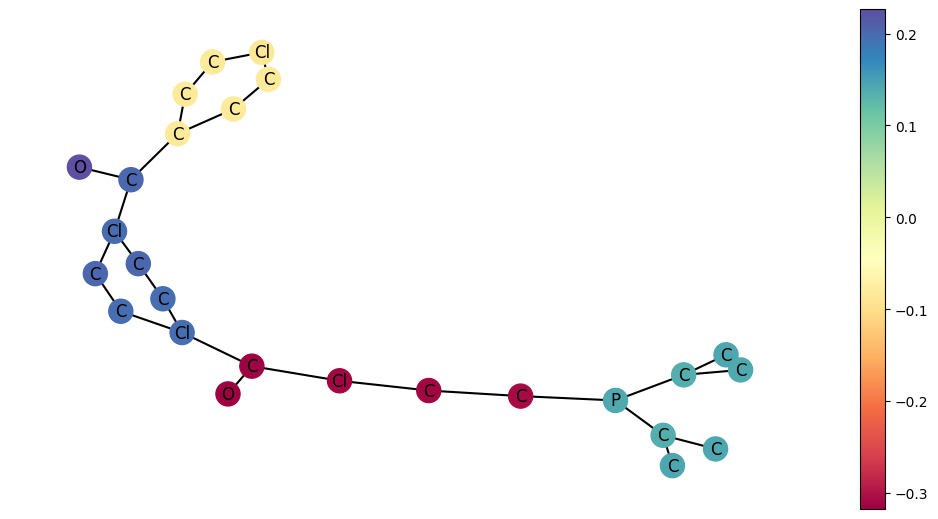

In [324]:
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, m.to("cpu").weight.detach().numpy()[:,4])

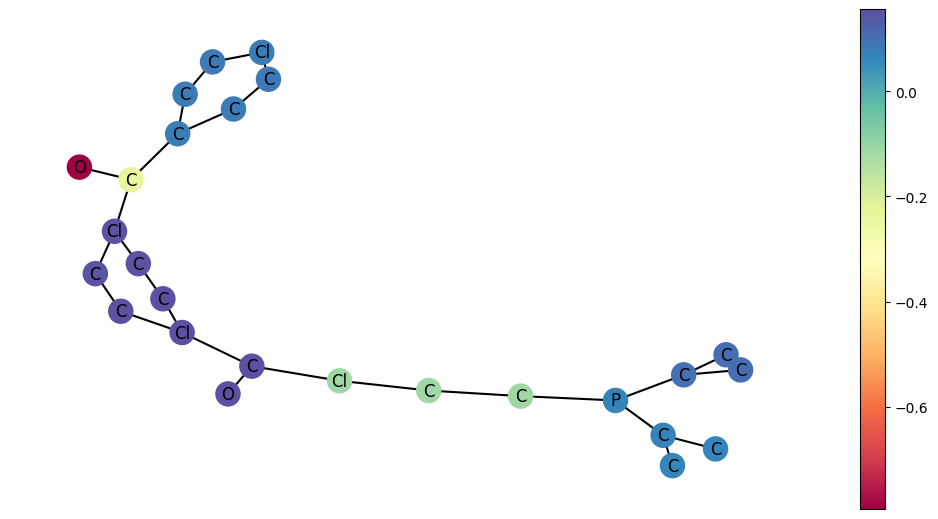

In [325]:
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, m.to("cpu").weight.detach().numpy()[:,5])

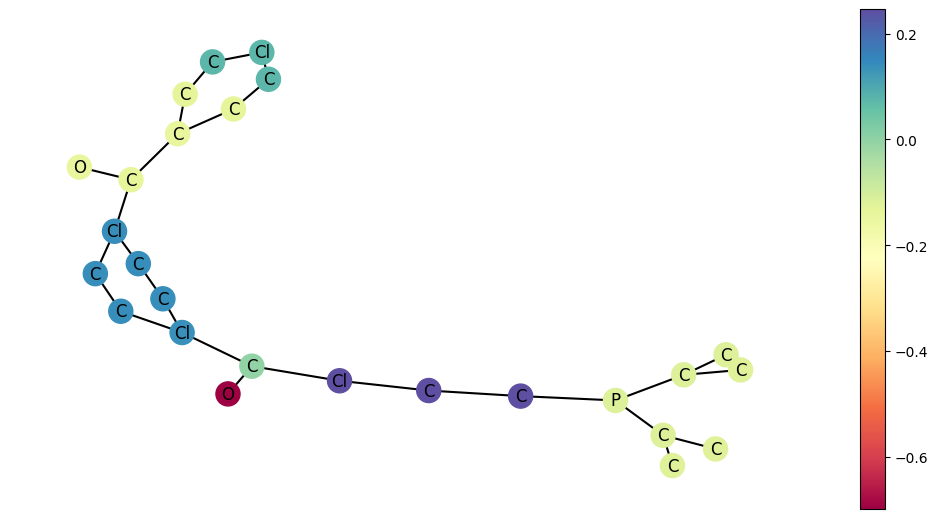

In [326]:
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, m.to("cpu").weight.detach().numpy()[:,6])

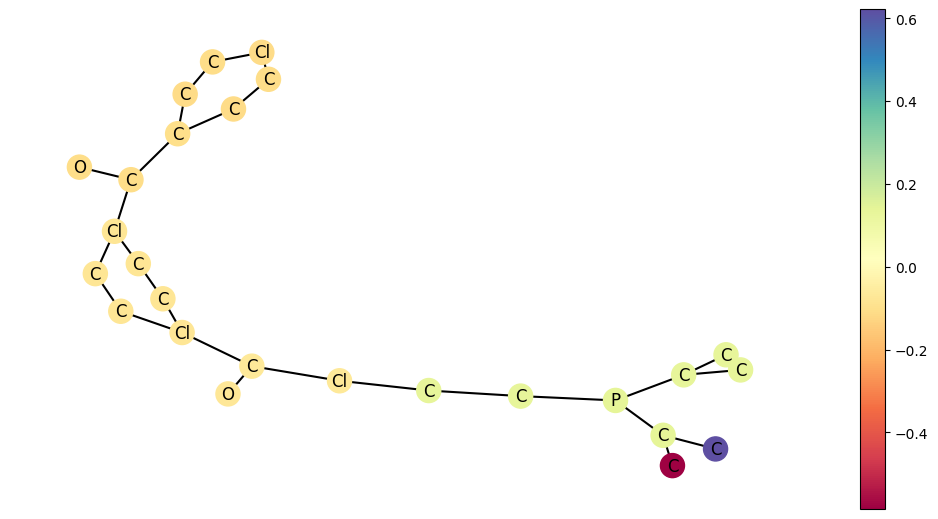

In [327]:
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, m.to("cpu").weight.detach().numpy()[:,7])

In [181]:
import seaborn as sns

In [212]:
import matplotlib.cm as cm

In [215]:
import matplotlib.cm as cm
import matplotlib as matplotlib

def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color

In [218]:
color_map_color(colors)

ValueError: Invalid RGBA argument: array([[1.        , 0.90914264, 0.10156094, 1.        ],
       [1.        , 0.9064975 , 0.09996155, 1.        ],
       [1.        , 0.90914264, 0.10156094, 1.        ]])

In [339]:
from numba import jit
eps = 0

In [340]:
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def phi(x, p):
  return np.abs(x)**(p-1)*np.sign(x)

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def lp_norm(x, p):
  #gives the p-th power of the lp-norm
  y = np.sum(np.power(np.abs(x),p))
  return y

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def jacobian_grad(A, f, p):
#A is the weight matrix and f denotes the current embedding of the nodes 
#(row is the node and column are the dimension of the embedding)
#implements equation (22)
  B = np.zeros((f.shape[0], f.shape[1]))
  for i in range(0, f.shape[0]):
    for k in range(0, f.shape[1]):
      helper = [ A[i,j]*phi(f[i,k] - f[j,k],p)  for j in range(0, f.shape[0]) ]
      grad = np.sum(np.array(helper))
      grad = grad - phi(f[i,k],p)/lp_norm(f[:,k], p)
      grad = 1/lp_norm(f[:,k], p) * grad
      B[i,k] = grad
  return B

def calc_grad(A, f,p):
#implements G in Algorithm 1
  grad = jacobian_grad(A, f, p)
  G = grad - np.matmul(np.matmul(f,np.transpose(grad)),f)
  step_size = lp_norm(f, 1)/lp_norm(G,1) #for the adaptive stepsize
  return G, step_size

In [341]:
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def derivative(A, f, p):
#A is the weight matrix and f denotes the current embedding of the nodes 
#(row is the node and column are the dimension of the embedding)
#implements equation (22)
  sum_rows = 0
  for i in range(0,A.shape[0]):
    sum_cols = 0
    for j in range(0,A.shape[1]):
      sum_cols = sum_cols + A[i,j]*(np.abs(f[i] - f[j])**p)/(2*lp_norm(f,p)+eps)
    sum_rows = sum_rows + sum_cols
  B = np.zeros(f.shape[0])
  for m in range(f.shape[0]):
    helper = [A[m,j]*phi(f[m] - f[j], p) for j in range(A.shape[0])]
    grad = np.sum(np.array(helper))
    B[m] = p/(lp_norm(f,p)+eps)*(grad- (phi(f[m],p)*sum_rows))
  return B

In [343]:
cols = m.to("cpu").weight.detach().numpy()

In [342]:
hi = derivative(A, cols[:,0], 1)

In [344]:
hi

array([-0.25113049,  0.18984115, -0.25113049, -0.25113049,  0.41032698,
       -0.47161631,  0.41032698, -0.69210213,  0.18984115,  0.6308128 ,
       -0.47161631,  0.41032698, -0.69210213,  0.18984115,  0.18984115,
       -0.69210213,  0.41032698, -0.47161631,  0.41032698, -0.47161631,
        0.41032698,  0.41032698, -0.47161631, -0.25113049,  0.41032698,
       -0.03064467])

In [399]:
K = 1

In [418]:
X = W
f = m.weight[:,9]
FF = f.repeat(1,m.n)
FF = FF.reshape(m.n,m.n,K)
#FFF = torch.sum(torch.pow(torch.abs(f), 1/p))
FFF = torch.norm(m.weight[:,9], m.p,dim=0)
FFF = torch.pow(FFF,m.p)
FF = FF.transpose(2,0)
GG =FF.transpose(1,2)
A = X.unsqueeze(dim=1)
#WW = A.unsqueeze(dim=-1)
#Ww = WW.expand(-1,-1,-1,3)
KK = FF - GG #this must be changed, since the values must be taken in norm and so on
KKK = KK.unsqueeze(dim=-1)
KKK = torch.pow(torch.abs(KKK),m.p)
#print(A.size(), KKK.size())
KKK = KKK.float()
A = A.float()
LL = torch.matmul(A, KKK)
FFF = torch.pow(FFF,-1)
FFF.unsqueeze_(-1)
FFF.unsqueeze_(-1)
FFF.unsqueeze_(-1)
FFF = FFF.repeat(1,m.n,1,1)
LL = LL.float()
FFF = FFF.float()
b = torch.matmul(LL,FFF)
b = torch.sum(b)

IndexError: index 9 is out of bounds for dimension 1 with size 9

In [419]:
b/2

tensor(0.7463, grad_fn=<DivBackward0>)

In [391]:
eigval

array([3.8901174e-16, 2.7003175e-02, 1.0957921e-01, 2.6794919e-01,
       3.0335054e-01, 5.2178603e-01, 6.5964335e-01, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.2425905e+00, 1.3988613e+00,
       1.5419742e+00, 2.3807693e+00, 2.7194188e+00, 3.0000000e+00,
       3.0000000e+00, 3.0000000e+00, 3.1360269e+00, 3.4560969e+00,
       3.6836786e+00, 3.7320509e+00, 4.2096910e+00, 4.7442317e+00,
       4.8779945e+00, 4.9873037e+00], dtype=float32)